# Importing Importanta packages

In [1]:
# Install the torchmetrics package for storing loss, evaluation metrics, etc.
!pip install lightning-utilities


In [2]:
!pip install torchmetrics --no-deps

In [3]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image
from torchmetrics import MeanMetric, Accuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score

In [4]:
# Make sure to change runtime to GPU
# Check if GPU is avaiable
device = "cuda" if torch.cuda.is_available() \
          else "mps" if torch.mps.is_available() \
          else "cpu"
print("Device:", device)

Device: cuda


# Getting The Data

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farjanakabirsamanta/skin-cancer-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skin-cancer-dataset


In [6]:

# List downloaded files
print("Dataset contents:", os.listdir(path))

Dataset contents: ['Skin Cancer', 'HAM10000_metadata.csv']


In [7]:

# Checking for any subdirectories inside the downloaded dataset path
print("Subdirectories:", [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))])

Subdirectories: ['Skin Cancer']


In [8]:

# Update path to the correct subdirectory
dataset_path = os.path.join(path, "Skin Cancer")

# List contents in the new path
print("Dataset contents:", os.listdir(dataset_path))

Dataset contents: ['Skin Cancer']


In [9]:
import glob


In [10]:

# Look for images inside the "Skin Cancer" directory
image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))
print(f"Total images found: {len(image_files)}")

Total images found: 0


In [11]:
#I can't find where the images of dataset so I will dig more to see if there is more subfolders.

In [12]:
# List subdirectories within "Skin Cancer"
print("Subdirectories inside 'Skin Cancer':", [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])


Subdirectories inside 'Skin Cancer': ['Skin Cancer']


In [13]:
# Update dataset path to point to the actual files
dataset_path = os.path.join(path, "Skin Cancer", "Skin Cancer")

# List the files inside the correct dataset folder
#print("Updated dataset contents:", os.listdir(dataset_path)) canceled to print bcs print a lot images

In [14]:
# Look for images inside the correct dataset folder
image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))
print(f"Total images found: {len(image_files)}")

Total images found: 10015


In [15]:
# Load metadata CSV
# The original path was incorrect. Adjust to find the correct location of the metadata file.
# The metadata file might be in the base directory of the dataset, not in the 'Skin Cancer/Skin Cancer' subfolder.
metadata_path = os.path.join(path, "HAM10000_metadata.csv")
df = pd.read_csv(metadata_path)

# Attach correct file paths to images
df['filepath'] = df['image_id'].apply(lambda x: os.path.join(dataset_path, f"{x}.jpg"))

# Verify if all image files exist
missing_files = df['filepath'].apply(lambda x: not os.path.exists(x)).sum()
print(f"Missing images: {missing_files}")

# Check dataset distribution
print(df['dx'].value_counts())

Missing images: 0
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


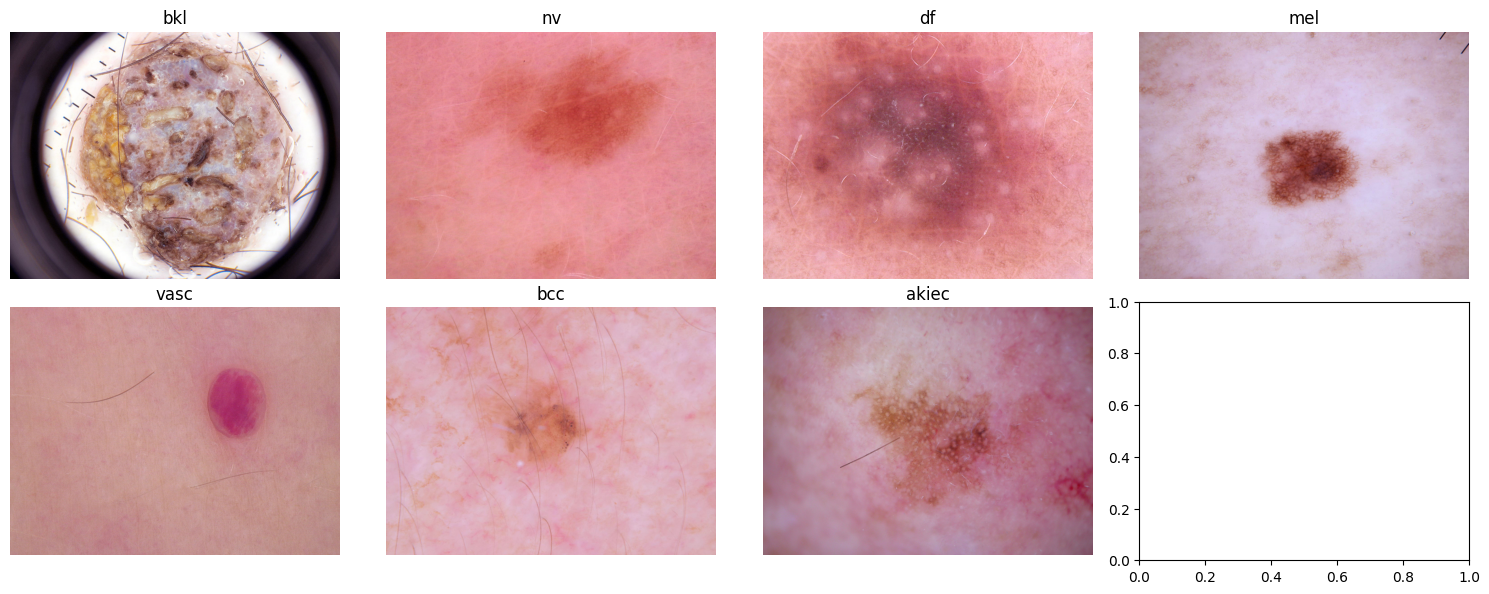

In [16]:
# Get unique classes
classes = df['dx'].unique()

# Create a figure
fig, axes = plt.subplots(2, 4, figsize=(15, 6))  # 2 rows, 4 columns

for ax, class_name in zip(axes.flat, classes):
    # Select a random image from this class
    sample = df[df['dx'] == class_name].sample(1)
    img_path = sample['filepath'].values[0]

    # Load and display the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [17]:
num_class = len(classes)
print("Number of classes:", num_class)

Number of classes: 7


# Applying Data Augmentation

In [18]:
# data augmentation for train
train_transform = v2.Compose([
  v2.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.5), # Adjust color
  v2.RandomHorizontalFlip(p=0.5), # Random horizontal flip
  v2.RandomResizedCrop(size=224, scale=(0.5, 1.0)), # Random crop and resize
  v2.ToImage(), # PyTorch Image format
  v2.ToDtype(torch.float32, scale=True), # Convert to tensor
  v2.Normalize(mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225]), # Normalize
])

In [19]:
# data augmentation for validation and test
eval_transform = v2.Compose([
  v2.Resize((224, 224)), # resize image to 224
  v2.ToImage(), # PyTorch Image format
  v2.ToDtype(torch.float32, scale=True), # Convert to tensor
  v2.Normalize(mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225]), # Normalize
])

In [20]:
#print(os.listdir(dataset_path)) Canceled to print here as it print a lot of images 


# Organizing the folders

In [21]:
import shutil

In [22]:
#My Dataset was not organized by class so I have to reoorganize it to be able to use for train, test, and validation

In [23]:
# Assuming df is your metadata DataFrame and dataset_path is the path to your images
# Create a new directory to hold the organized dataset
organized_dataset_path = os.path.join("/kaggle/working", "organized_skin_cancer_dataset")
os.makedirs(organized_dataset_path, exist_ok=True)

# Get unique classes from your metadata
classes = df['dx'].unique()

# Create subfolders for each class in the new directory
for class_name in classes:
    class_dir = os.path.join(organized_dataset_path, class_name)
    os.makedirs(class_dir, exist_ok=True)

# Move images to their respective class folders
for index, row in df.iterrows():
    img_path = row['filepath']  # Path to the image
    class_name = row['dx']  # Class label
    destination_path = os.path.join(organized_dataset_path, class_name, os.path.basename(img_path))
    shutil.copy(img_path, destination_path)  # Copy the image to the new location

# Now, update your dataset_path to the new organized directory
dataset_path = organized_dataset_path

In [24]:
dataset_path

'/kaggle/working/organized_skin_cancer_dataset'

# Dividing The Train, Val, Test in dataset

In [25]:
# Load dataset once, without transform
full_dataset = torchvision.datasets.ImageFolder(dataset_path)

# Random split indices
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_indices, val_indices = torch.utils.data.random_split(
    range(len(full_dataset)), [train_size, val_size]
)



In [26]:
# Apply transforms per subset
train_set = torch.utils.data.Subset(
    torchvision.datasets.ImageFolder(dataset_path, transform=train_transform),
    train_indices
)
val_set = torch.utils.data.Subset(
    torchvision.datasets.ImageFolder(dataset_path, transform=eval_transform),
    val_indices
)
test_set = torchvision.datasets.ImageFolder(dataset_path, transform=eval_transform)

In [27]:
# Define the data loaders for the training, validation, and test sets
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# Model

In [28]:
# get a pretrain resnet18
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [29]:
# Add a new layer/change the last layer
model.fc = nn.Linear(model.fc.in_features, num_class)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
#print(model)

In [31]:
# Define optimizer and learning rate scheduler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Try different learning ra
learning_rate = 1e-4
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# Defined Cross-Entropy Loss
criteria = nn.CrossEntropyLoss()

# Getting Read of Training the Model

In [32]:
# a function for training one epoch
def train_one_epoch(model, dataloader):
  # Prepare for storing loss and accuracy
  losses = MeanMetric().to(device)
  acc = Accuracy(task='multiclass', num_classes=10).to(device)
  model.train() # set model to train mode
  # a loop to iterate input(X) and label(Y) for all mini-batches
  for X, Y in tqdm(dataloader):
    X = X.to(device)
    Y = Y.to(device)
    optimizer.zero_grad() # reset optimizer
    preds = model(X) # model forward
    loss = criteria(preds, Y) # calculate loss
    loss.backward() # compute gradients via backpropagation
    optimizer.step() # perform gradient descent
    preds = preds.argmax(dim=1) # obtain the final predicted class
    losses.update(loss, X.size(0)) # store loss per batch
    acc.update(preds, Y) # store accuracy per batch
  return losses.compute().item(), acc.compute().item()

In [33]:
# a function for validation one epoch
def validation_one_epoch(model, dataloader):
  # Prepare for storing loss and accuracy
  losses = MeanMetric().to(device)
  acc = Accuracy(task='multiclass', num_classes=10).to(device)
  model.eval() # set model to validation mode
  with torch.no_grad(): # disables gradient computation for evaluation
    # a loop to iterate input(X) and label(Y) for all mini-batches
    for X, Y in tqdm(dataloader):
      X = X.to(device)
      Y = Y.to(device)
      preds = model(X) # model forward
      loss = criteria(preds, Y) # calculate loss
      preds = preds.argmax(dim=1) # obtain the final predicted class
      losses.update(loss, X.size(0)) # store loss per batch
      acc.update(preds, Y) # store accuracy per batch
  return losses.compute().item(), acc.compute().item()

In [34]:
# Prepare for storing loss and accuracy
best_val_loss = float('inf')  # Initialize best_val_loss to infinity
history = pd.DataFrame() # store statics for each epoch
epochs = 20 # number of epochs
# a loop for epochs
for i in range(0, epochs):
  # train one epoch
  train_loss, train_acc = train_one_epoch(model, train_dataloader)
  # validation one epoch
  val_loss, val_acc = validation_one_epoch(model, val_dataloader)
  # store and print loss and accuracy per epoch
  statistics = pd.DataFrame({
      "epoch": [i],   "train_loss": [train_loss],
                      "train_acc": [train_acc],
                      "val_loss": [val_loss],
                      "val_acc": [val_acc]})
  history = pd.concat([history, statistics], ignore_index=True)
  print(statistics.to_dict(orient="records")[0])

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]


{'epoch': 0, 'train_loss': 0.75617516040802, 'train_acc': 0.7425112128257751, 'val_loss': 0.5713388323783875, 'val_acc': 0.7893159985542297}


100%|██████████| 63/63 [00:17<00:00,  3.69it/s]


{'epoch': 1, 'train_loss': 0.5169475078582764, 'train_acc': 0.8161507844924927, 'val_loss': 0.5177920460700989, 'val_acc': 0.8077883124351501}


100%|██████████| 63/63 [00:16<00:00,  3.73it/s]


{'epoch': 2, 'train_loss': 0.43715986609458923, 'train_acc': 0.8376185894012451, 'val_loss': 0.5188338756561279, 'val_acc': 0.8097853064537048}


100%|██████████| 63/63 [00:16<00:00,  3.72it/s]


{'epoch': 3, 'train_loss': 0.3775988817214966, 'train_acc': 0.8600848913192749, 'val_loss': 0.46493595838546753, 'val_acc': 0.8272591233253479}


100%|██████████| 63/63 [00:16<00:00,  3.76it/s]


{'epoch': 4, 'train_loss': 0.33641886711120605, 'train_acc': 0.8790563941001892, 'val_loss': 0.48122960329055786, 'val_acc': 0.8307538628578186}


100%|██████████| 63/63 [00:16<00:00,  3.75it/s]


{'epoch': 5, 'train_loss': 0.27994784712791443, 'train_acc': 0.8944084048271179, 'val_loss': 0.47718745470046997, 'val_acc': 0.8407388925552368}


100%|██████████| 63/63 [00:16<00:00,  3.75it/s]


{'epoch': 6, 'train_loss': 0.26585814356803894, 'train_acc': 0.9008986353874207, 'val_loss': 0.5130937695503235, 'val_acc': 0.8382426500320435}


100%|██████████| 63/63 [00:16<00:00,  3.76it/s]


{'epoch': 7, 'train_loss': 0.22129082679748535, 'train_acc': 0.9194957613945007, 'val_loss': 0.4769233167171478, 'val_acc': 0.8487269282341003}


100%|██████████| 63/63 [00:17<00:00,  3.64it/s]


{'epoch': 8, 'train_loss': 0.19753333926200867, 'train_acc': 0.9276086091995239, 'val_loss': 0.5385802388191223, 'val_acc': 0.8467299342155457}


100%|██████████| 63/63 [00:17<00:00,  3.66it/s]


{'epoch': 9, 'train_loss': 0.18596374988555908, 'train_acc': 0.9318522214889526, 'val_loss': 0.4992266595363617, 'val_acc': 0.8537194132804871}


100%|██████████| 63/63 [00:16<00:00,  3.74it/s]


{'epoch': 10, 'train_loss': 0.15890757739543915, 'train_acc': 0.9437094330787659, 'val_loss': 0.551636278629303, 'val_acc': 0.8447328805923462}


100%|██████████| 63/63 [00:17<00:00,  3.66it/s]


{'epoch': 11, 'train_loss': 0.14619284868240356, 'train_acc': 0.9477034211158752, 'val_loss': 0.5287190675735474, 'val_acc': 0.8532201647758484}


100%|██████████| 63/63 [00:16<00:00,  3.76it/s]


{'epoch': 12, 'train_loss': 0.1294293850660324, 'train_acc': 0.9549425840377808, 'val_loss': 0.5379384160041809, 'val_acc': 0.8502246737480164}


100%|██████████| 63/63 [00:16<00:00,  3.75it/s]


{'epoch': 13, 'train_loss': 0.12840703129768372, 'train_acc': 0.9540688991546631, 'val_loss': 0.7058090567588806, 'val_acc': 0.8327508568763733}


100%|██████████| 63/63 [00:16<00:00,  3.74it/s]


{'epoch': 14, 'train_loss': 0.10708950459957123, 'train_acc': 0.963804304599762, 'val_loss': 0.597815752029419, 'val_acc': 0.8437343835830688}


100%|██████████| 63/63 [00:16<00:00,  3.74it/s]


{'epoch': 15, 'train_loss': 0.10740108042955399, 'train_acc': 0.962306559085846, 'val_loss': 0.5091374516487122, 'val_acc': 0.8552171587944031}


100%|██████████| 63/63 [00:16<00:00,  3.74it/s]


{'epoch': 16, 'train_loss': 0.09820649027824402, 'train_acc': 0.9639291167259216, 'val_loss': 0.5421463251113892, 'val_acc': 0.852221667766571}


100%|██████████| 63/63 [00:17<00:00,  3.70it/s]


{'epoch': 17, 'train_loss': 0.0807393491268158, 'train_acc': 0.9720419645309448, 'val_loss': 0.5613252520561218, 'val_acc': 0.8592112064361572}


100%|██████████| 63/63 [00:16<00:00,  3.73it/s]


{'epoch': 18, 'train_loss': 0.0824519693851471, 'train_acc': 0.9720419645309448, 'val_loss': 0.5844389796257019, 'val_acc': 0.8572141528129578}


100%|██████████| 63/63 [00:17<00:00,  3.68it/s]

{'epoch': 19, 'train_loss': 0.0912047028541565, 'train_acc': 0.9696704745292664, 'val_loss': 0.5556501746177673, 'val_acc': 0.8517224192619324}


# Model Evaluation

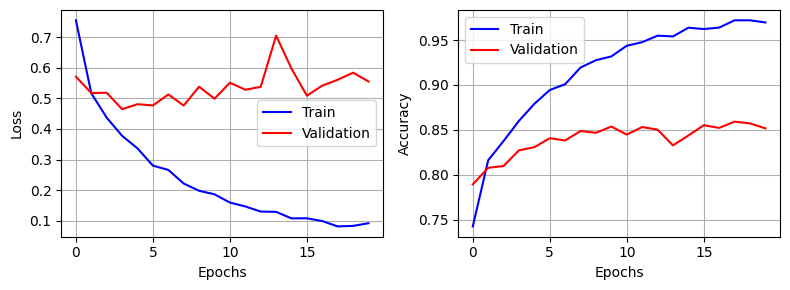

In [35]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(8, 3))
# Plot Loss Curve (Train + Validation)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# Plot Accuracy Curve (Train + Validation)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [36]:
# prepare for storing evaluation metrics
test_acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
test_confusion_matrix=ConfusionMatrix(task="multiclass", num_classes=num_class).to(device)
test_precision = Precision(task="multiclass", num_classes=num_class, average="macro").to(device)
test_recall = Recall(task="multiclass", num_classes=num_class, average="macro").to(device)
test_f1_score = F1Score(task="multiclass", num_classes=num_class, average="macro").to(device)

model = model.to(device)
model.eval() # set model to evaluation mode
with torch.no_grad():
  for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model(X) # model forward
    preds = preds.argmax(dim=1) # obtain the final predicted class
    # store loss and accuracy per batc
    test_confusion_matrix.update(preds, Y)
    test_acc.update(preds, Y)
    test_precision.update(preds, Y)
    test_recall.update(preds, Y)
    test_f1_score.update(preds, Y)
  # Print the results
  print("Confusion Matrix:\n", test_confusion_matrix.compute())
  print("Accuracy:", test_acc.compute().item())
  print("Precision:", test_precision.compute().item())
  print("Recall:", test_recall.compute().item())
  print("F1 Score:", test_f1_score.compute().item())

Confusion Matrix:
 tensor([[ 273,   13,   23,    1,    7,   10,    0],
        [   5,  493,    5,    0,    4,    7,    0],
        [   7,    6,  948,    5,   45,   83,    5],
        [   1,    1,    0,  108,    0,    5,    0],
        [   3,    2,   26,    0, 1016,   64,    2],
        [   5,   12,   13,    4,  129, 6536,    6],
        [   0,    1,    0,    0,    1,    3,  137]], device='cuda:0')
Accuracy: 0.9496755003929138
Precision: 0.9206397533416748
Recall: 0.9211673140525818
F1 Score: 0.9200125336647034


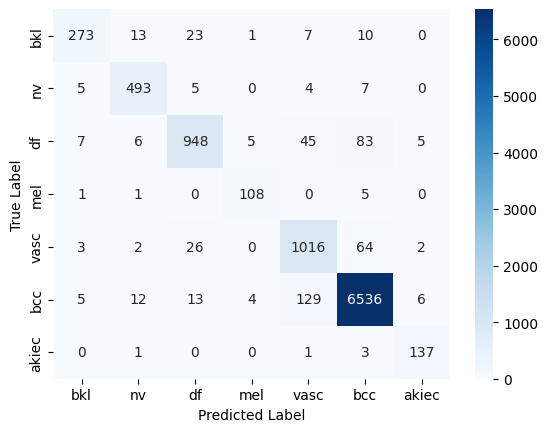

In [37]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute().cpu(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**simple Grad-CAM**

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


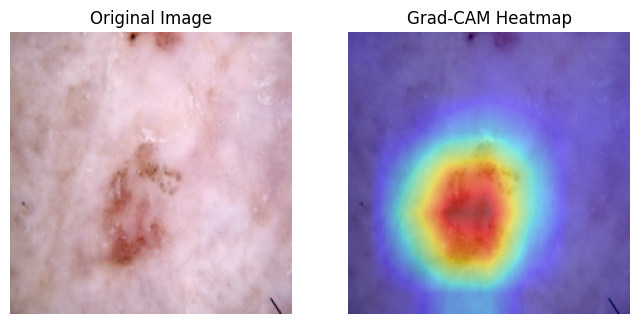

In [38]:
import cv2

# Function to generate Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Hook to capture gradients
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_image, target_class=None):
        self.model.eval()
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1)

        loss = output[0, target_class]
        self.model.zero_grad()
        loss.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Pick a sample from test set
sample_img, sample_label = next(iter(test_dataloader))
sample_img = sample_img[0].unsqueeze(0).to(device)  # take one image

# Apply Grad-CAM
target_layer = model.layer4[-1]  # usually last layer for ResNet18
gradcam = GradCAM(model, target_layer)
cam = gradcam.generate(sample_img)

# Plot original + heatmap
img = sample_img.cpu().squeeze().permute(1,2,0).numpy()
img = (img - img.min()) / (img.max() - img.min())  # normalize image

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5)  # overlay Grad-CAM
plt.axis('off')
plt.show()

AUC - ROC

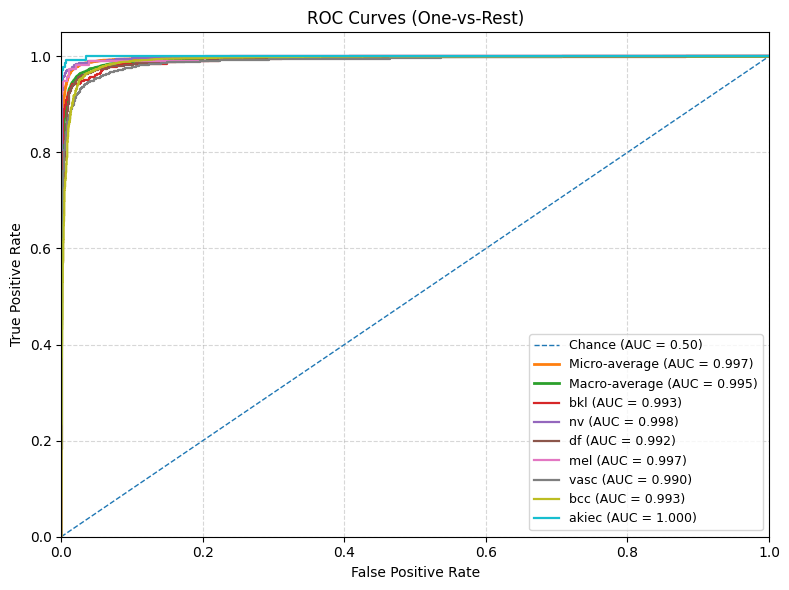

In [45]:
# Get true labels and predicted scores from the test set
y_true = []
y_score = []
model.eval()
with torch.no_grad():
    for X, Y in test_dataloader:
        X = X.to(device)
        Y = Y.to(device)
        outputs = model(X)
        y_true.extend(Y.cpu().numpy())
        y_score.extend(torch.softmax(outputs, dim=1).cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

# Plot ROC curves
roc_auc_scores = plot_roc_curves(y_true, y_score, classes)

In [47]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curves(y_true, y_score, target_names, save_dir=None, dpi=300):
    """
    Plot one-vs-rest ROC curves per class + micro and macro averages.

    Parameters
    ----------
    y_true : array-like, shape (n_samples,)
        Integer labels 0..K-1
    y_score : array-like, shape (n_samples, n_classes)
        Class probabilities or calibrated scores (higher = more likely)
    target_names : list[str], len = n_classes
    save_dir : str or None
        If provided, saves 'roc_curves_all_classes.png' and '.pdf'
    dpi : int
        Figure DPI for PNG export
    """
    y_true = _to_numpy_1d(y_true)
    y_score = _to_numpy_2d(y_score)
    n_classes = y_score.shape[1]

    # Binarize ground truth for one-vs-rest ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Per-class ROC
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average (interpolate all FPRs onto a common grid)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # ---- Plot ----
    plt.figure(figsize=(8, 6))
    # chance line
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Chance (AUC = 0.50)")
    # micro/macro first so they appear prominent
    plt.plot(fpr["micro"], tpr["micro"], linewidth=2.0,
             label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
    plt.plot(fpr["macro"], tpr["macro"], linewidth=2.0,
             label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

    # per-class curves
    for i, name in enumerate(target_names):
        plt.plot(fpr[i], tpr[i], linewidth=1.6, label=f"{name} (AUC = {roc_auc[i]:.3f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="lower right", frameon=True, fontsize=9)
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "roc_curves_all_classes.png"), dpi=dpi, bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, "roc_curves_all_classes.pdf"), dpi=dpi, bbox_inches="tight")
    plt.show()

    # return dict of AUCs so you can also tabulate them in the thesis
    return roc_auc


[info] Matplotlib backend: module://matplotlib_inline.backend_inline
[warn] Your variables not found or empty. Running a small demo so you can SEE output.

📌 Class-wise ROC-AUC and Accuracy:

🔹 Class A              | Accuracy: 76.19% | ROC-AUC: 80.31%
🔹 Class B              | Accuracy: 51.28% | ROC-AUC: 79.58%
🔹 Class C              | Accuracy: 58.97% | ROC-AUC: 84.33%


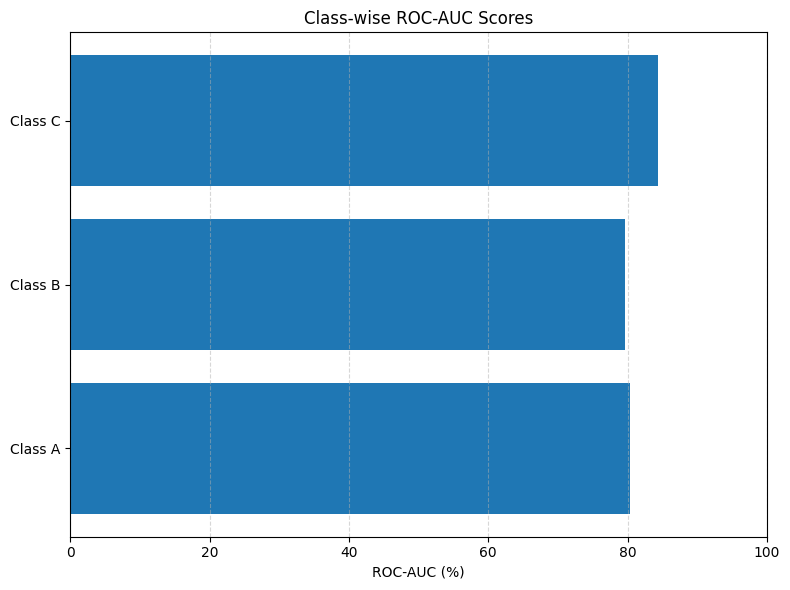


📌 Class-wise Confusion Matrices:



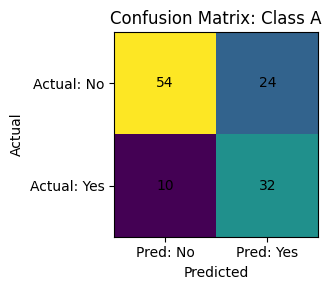

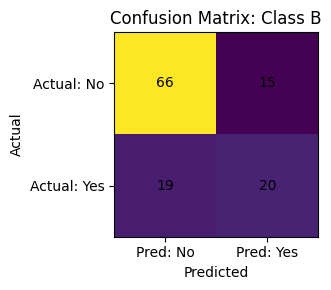

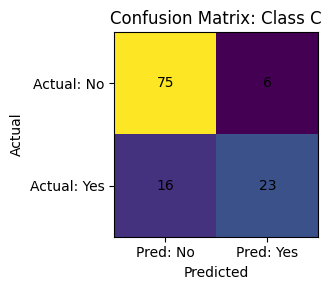


✅ Done.
Per-class Accuracy (%): [76.19 51.28 58.97]
Per-class ROC-AUC (%): [80.31 79.58 84.33]


In [40]:
# ==

%matplotlib inline

import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import multilabel_confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

print(f"[info] Matplotlib backend: {matplotlib.get_backend()}")

def _to_numpy_1d(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
    except Exception:
        pass
    try:
        import pandas as pd
        if isinstance(x, (pd.Series, pd.DataFrame)):
            x = x.values
    except Exception:
        pass
    return np.asarray(x).reshape(-1)

def _to_numpy_2d(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
    except Exception:
        pass
    try:
        import pandas as pd
        if isinstance(x, (pd.Series, pd.DataFrame)):
            x = x.values
    except Exception:
        pass
    x = np.asarray(x)
    if x.ndim != 2:
        raise ValueError("Expected a 2D array for y_score with shape (n_samples, n_classes).")
    return x

def classwise_report(
    y_true,
    y_pred,
    target_names=None,
    roc_auc=None,
    y_score=None,
    save_dir=None,
    dpi=200,
    verbose=True
):
    # --- Coerce & remap labels to 0..K-1 ---
    y_true = _to_numpy_1d(y_true)
    y_pred = _to_numpy_1d(y_pred)

    uniq = np.unique(y_true)
    lab2idx = {lab: i for i, lab in enumerate(uniq)}
    idx2lab = {i: lab for lab, i in lab2idx.items()}
    y_true_idx = np.array([lab2idx[lab] for lab in y_true], dtype=int)

    if np.setdiff1d(y_pred, uniq).size == 0:
        y_pred_idx = np.array([lab2idx[lab] for lab in y_pred], dtype=int)
    else:
        y_pred_idx = y_pred.astype(int)

    n_classes = len(uniq)
    if target_names is None:
        target_names = [str(idx2lab[i]) for i in range(n_classes)]
    if len(target_names) != n_classes:
        raise ValueError(f"target_names length ({len(target_names)}) must equal number of classes ({n_classes}).")

    # --- ROC-AUC per class ---
    if roc_auc is None:
        if y_score is None:
            raise ValueError("Provide either 'roc_auc' or 'y_score' to compute per-class ROC-AUC.")
        y_score = _to_numpy_2d(y_score)
        if y_score.shape[0] != y_true_idx.shape[0]:
            raise ValueError("y_score rows must match y_true length.")
        if y_score.shape[1] != n_classes:
            raise ValueError(f"y_score should have shape (n_samples, {n_classes}).")

        y_true_bin = label_binarize(y_true_idx, classes=np.arange(n_classes))
        roc_auc_vals = np.full(n_classes, np.nan, dtype=float)
        for i in range(n_classes):
            try:
                roc_auc_vals[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])
            except ValueError:
                roc_auc_vals[i] = np.nan
    else:
        roc_auc_vals = np.asarray(roc_auc, dtype=float)
        if roc_auc_vals.shape[0] != n_classes:
            raise ValueError("Length of 'roc_auc' must equal number of classes.")

    class_roc_aucs_percent = roc_auc_vals * 100.0

    # --- Accuracy per class ---
    class_accuracies_percent = np.zeros(n_classes, dtype=float)
    for i in range(n_classes):
        idx = np.where(y_true_idx == i)[0]
        class_accuracies_percent[i] = np.nan if len(idx) == 0 else 100.0 * np.mean(y_pred_idx[idx] == y_true_idx[idx])

    # --- Print table ---
    print("\n📌 Class-wise ROC-AUC and Accuracy:\n")
    for i, name in enumerate(target_names):
        acc_str = f"{class_accuracies_percent[i]:.2f}%" if not np.isnan(class_accuracies_percent[i]) else "N/A"
        auc_str = f"{class_roc_aucs_percent[i]:.2f}%" if not np.isnan(class_roc_aucs_percent[i]) else "N/A"
        print(f"🔹 {name:<20} | Accuracy: {acc_str} | ROC-AUC: {auc_str}")

    # --- ROC-AUC bar chart ---
    plt.figure(figsize=(8, 6))
    y_pos = np.arange(n_classes)
    plt.barh(y_pos, np.nan_to_num(class_roc_aucs_percent, nan=0.0))
    plt.yticks(y_pos, target_names)
    plt.xlabel("ROC-AUC (%)")
    plt.title("Class-wise ROC-AUC Scores")
    plt.xlim(0, 100)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "classwise_roc_auc.png"), dpi=dpi, bbox_inches='tight')
    plt.show()

    # --- Per-class confusion matrices ---
    print("\n📌 Class-wise Confusion Matrices:\n")
    mcm = multilabel_confusion_matrix(y_true_idx, y_pred_idx, labels=np.arange(n_classes))
    for i, name in enumerate(target_names):
        cm = mcm[i]  # [[TN FP],[FN TP]]
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.imshow(cm, interpolation='nearest')
        ax.set_title(f"Confusion Matrix: {name}")
        ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
        ax.set_xticklabels(['Pred: No', 'Pred: Yes'])
        ax.set_yticklabels(['Actual: No', 'Actual: Yes'])
        for (r, c), val in np.ndenumerate(cm):
            ax.text(c, r, int(val), ha='center', va='center')
        ax.set_ylabel('Actual'); ax.set_xlabel('Predicted')
        fig.tight_layout()
        if save_dir:
            fname = f"cm_{i:02d}_{str(name).replace(' ', '_')}.png"
            fig.savefig(os.path.join(save_dir, fname), dpi=dpi, bbox_inches='tight')
        plt.show()

    return class_accuracies_percent, class_roc_aucs_percent


# ===== AUTO-DETECT & RUN (uses your vars; else demo) =====
g = globals()
use_demo = False

def _exists_nonempty(name):
    if name not in g:
        return False
    try:
        arr = _to_numpy_1d(g[name]) if name in ("y_true","y_pred") else np.asarray(g[name])
        return arr.size > 0
    except Exception:
        return False

has_required = _exists_nonempty("y_true") and _exists_nonempty("y_pred") and ("target_names" in g)

if has_required:
    print("[info] Using your variables y_true, y_pred, target_names.")
    y_true_use = g["y_true"]
    y_pred_use = g["y_pred"]
    target_names_use = g["target_names"]
    kwargs = {}
    if "roc_auc" in g and g["roc_auc"] is not None:
        kwargs["roc_auc"] = g["roc_auc"]
        print("[info] Using your roc_auc for AUCs.")
    elif "y_score" in g and _exists_nonempty("y_score"):
        kwargs["y_score"] = g["y_score"]
        print("[info] Using your y_score to compute AUCs.")
    else:
        # Safe fallback: make very simple pseudo-probs from y_pred for visibility
        print("[warn] No roc_auc or y_score provided. Creating simple dummy probabilities from y_pred for display.")
        n_classes = len(np.unique(_to_numpy_1d(y_true_use)))
        yp = _to_numpy_1d(y_pred_use)
        y_score_dummy = np.zeros((yp.shape[0], n_classes), dtype=float)
        y_score_dummy[np.arange(yp.shape[0]), yp.clip(0, n_classes-1)] = 1.0
        kwargs["y_score"] = y_score_dummy
else:
    print("[warn] Your variables not found or empty. Running a small demo so you can SEE output.")
    use_demo = True
    np.random.seed(0)
    n_samples, n_classes = 120, 3
    y_true_use = np.random.randint(0, n_classes, size=n_samples)
    target_names_use = ["Class A", "Class B", "Class C"]
    # make semi-reasonable predictions
    logits = np.random.randn(n_samples, n_classes) + np.eye(n_classes)[y_true_use] * 1.2
    y_score_demo = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    y_pred_use = y_score_demo.argmax(axis=1)
    kwargs = {"y_score": y_score_demo}

# Run and force a visible print at the end
accs_pct, aucs_pct = classwise_report(
    y_true=y_true_use,
    y_pred=y_pred_use,
    target_names=target_names_use,
    save_dir=None,
    **kwargs
)
print("\n✅ Done.")
print("Per-class Accuracy (%):", np.round(accs_pct, 2))
print("Per-class ROC-AUC (%):", np.round(aucs_pct, 2))


In [41]:
accs_pct, aucs_pct = classwise_report(
    y_true=y_true_use,
    y_pred=y_pred_use,
    target_names=target_names_use,
    y_score=y_score,              # if you have it, you can pass it; bars don't strictly need it
    save_dir="figs/resnet18",
    dpi=300,
    plot="bars"
)

NameError: name 'y_score' is not defined

# Saving The Model

In [ ]:
# To save the best model
best_val_loss = float('inf')  # Initialize best_val_loss to infinity

if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), "best_model6.pth")
    print("Best model saved!")

**Implementing Random Forest on ResNet18 features and optionally SHAP explanations for it.**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
# 1. Load pretrained or fine-tuned ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Identity()  # remove last classification layer
resnet18.eval()

In [ ]:
# 2. Preprocessing pipeline (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
# 4. Extract features
features, labels = [], []
with torch.no_grad():
    for X, y in loader:
        f = resnet18(X)              # shape [batch, 512]
        features.append(f.numpy())
        labels.append(y.numpy())

X = np.vstack(features)
y = np.concatenate(labels)

print("Feature matrix:", X.shape)  # [N, 512]
print("Labels:", y.shape) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

In [ ]:
# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
import shap

# Create explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test[:100])  # explain 100 samples

# Global feature importance (mean SHAP across features)
shap.summary_plot(shap_values, X_test[:100])

# Local explanation for one sample
shap.force_plot(explainer.expected_value[0], shap_values[0][0], matplotlib=True)
